In [1]:
!pip install praat-parselmouth
# 필요한 라이브러리 설치
!pip install pydub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 58.7 MB/s eta 0:00:00


In [39]:
from pydub import AudioSegment

# M4A 파일을 WAV로 변환
audio = AudioSegment.from_file("1.m4a", format="m4a")
audio.export("1.wav", format="wav")
audio2 = AudioSegment.from_file("2.m4a", format="m4a")
audio2.export("2.wav", format="wav")
audio3 = AudioSegment.from_file("3.m4a", format="m4a")
audio3.export("3.wav", format="wav")


<_io.BufferedRandom name='3.wav'>

음성 분석

인간 음성 분석

In [40]:
import numpy as np
import parselmouth

def get_pitch_median(file_path):
    """
    주어진 WAV 파일에서 피치의 중간값을 계산하는 함수.

    Args:
        file_path (str): WAV 파일 경로.

    Returns:
        pitch_median (float): 0이 아닌 피치 값들의 중간값.
    """
    # WAV 파일 로드
    snd = parselmouth.Sound(file_path)

    # 피치 분석
    pitch = snd.to_pitch()

    # 피치 값과 해당 시간 단계 가져오기
    pitch_values = pitch.selected_array["frequency"]

    # 0이 아닌 피치 값만 필터링
    non_zero_pitch_values = pitch_values[pitch_values > 0]

    # 중간값 계산
    if len(non_zero_pitch_values) > 0:
        pitch_median = np.median(non_zero_pitch_values)
    else:
        pitch_median = 0  # 만약 0이 아닌 피치가 없다면 0으로 처리

    return pitch_median


In [42]:
low_pitch_median = get_pitch_median("1.wav")
high_pitch_median = get_pitch_median("2.wav")
print(low_pitch_median)
print(high_pitch_median)

87.09954808365006
252.83457630562302


In [46]:
import scipy.io.wavfile as wav
import numpy as np
import matplotlib.pyplot as plt
import parselmouth

def process_and_save_filtered_audio(low_pitch_median, high_pitch_median, input_file_path, output_file_path, extend_ms=50, silence_after_ms=150):
    """
    입력 WAV 파일에서 인간 음역대만 필터링하여 결과를 반환하고, 새 파일로 저장하는 함수.
    저음과 고음 음성 파일의 피치 중간값을 기준으로 필터링 범위를 동적으로 설정.

    Args:
        low_pitch_median (float): 저음 음성 파일의 피치 중간값
        high_pitch_median (float): 고음 음성 파일의 피치 중간값
        input_file_path (str): 필터링할 입력 WAV 파일 경로
        output_file_path (str): 필터링된 오디오를 저장할 출력 WAV 파일 경로
        extend_ms (int): 유지할 구간의 길이 (밀리초 단위)
        silence_after_ms (int): 음성 후 여유 시간 (밀리초 단위)

    Returns:
        filtered_data (numpy.ndarray): 필터링된 오디오 데이터
        pitch_values (numpy.ndarray): 필터링된 피치 값 배열
        time_steps (numpy.ndarray): 시간 단계 배열
    """
    # 1. 저음 및 고음 음성 파일에서 피치 중간값을 계산한 후, 이를 기준으로 음성 범위를 설정
    # human_voice_range는 저음과 고음의 피치 중간값을 기준으로 설정됨

    # 2. 인간 음성 범위는 저음과 고음의 피치 중간값을 기준으로 설정
    human_voice_range = (low_pitch_median, high_pitch_median)
    print(f"Calculated human voice range: {human_voice_range}")

    # 3. WAV 파일 로드
    sampling_rate, data = wav.read(input_file_path)

    # 스테레오인 경우, 채널을 평균하여 모노로 변환
    if len(data.shape) > 1:
        data = data.mean(axis=1).astype(np.int16)

    # 4. parselmouth로 음성 분석
    snd = parselmouth.Sound(data, sampling_rate)

    # 피치 분석 수행
    pitch = snd.to_pitch()

    # 피치 값과 해당 시간 단계 가져오기
    pitch_values = pitch.selected_array["frequency"]
    time_steps = pitch.xs()

    # 5. 히스테리시스 필터 적용: 필터링된 데이터를 저장할 배열 생성
    filtered_data = np.zeros_like(data, dtype=np.float32)
    filtered_pitch_values = np.zeros_like(pitch_values)

    prev_in_range = False

    # 샘플 수로 변환: 밀리초를 샘플 수로 변환
    extend_samples = int(sampling_rate * extend_ms / 1000)
    silence_samples = int(sampling_rate * silence_after_ms / 1000)

    # 6. 필터링: 피치 값이 인간 음성 범위에 있는지 확인하고 필터링 적용
    for i, t in enumerate(time_steps):
        index = int(t * sampling_rate)

        # 현재 피치가 인간 음역대에 해당하는지 확인
        in_range = human_voice_range[0] <= pitch_values[i] <= human_voice_range[1]

        if in_range or prev_in_range:
            # 앞뒤로 extend_ms만큼 구간을 유지하며 필터링
            start = max(0, index - extend_samples)
            end = min(len(data), index + extend_samples + silence_samples)
            filtered_data[start:end] = data[start:end]

            # 필터링된 피치 값을 업데이트
            filtered_pitch_values[i] = pitch_values[i] if in_range else 0

        prev_in_range = in_range

    # 7. 결과 WAV 파일로 저장
    wav.write(output_file_path, sampling_rate, filtered_data.astype(np.int16))

    print(f"{output_file_path} 파일이 생성되었습니다.")

    # 8. 필터링된 피치 값과 필터링되지 않은 피치 값을 시각화
    plt.figure(figsize=(10, 6))

    # 필터링되지 않은 피치 값 (원본 피치)
    plt.plot(time_steps, pitch_values, label="Original Pitch", color='blue', alpha=0.6, marker='x', linestyle='None')

    # 필터링된 피치 값
    plt.plot(time_steps, filtered_pitch_values, label="Filtered Pitch", color='red', alpha=0.6, marker='o', linestyle='None')

    plt.title('Pitch Values Over Time')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.ylim(min(pitch_values), 300)
    plt.legend()
    plt.grid(True)
    plt.show()

    return sampling_rate, filtered_data, filtered_pitch_values, time_steps


Calculated human voice range: (87.09954808365006, 252.83457630562302)
real_test_only.wav 파일이 생성되었습니다.


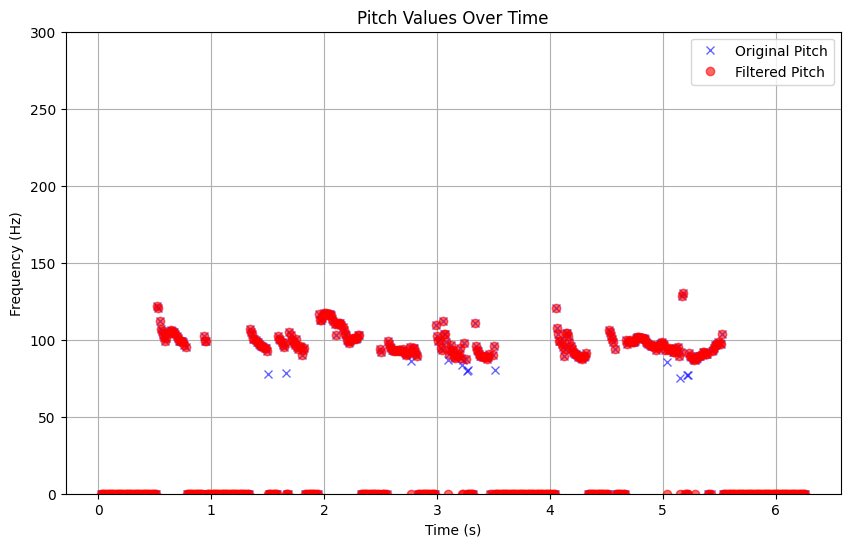

In [47]:
# 예시 사용
sampling_rate, filtered_data, pitch_values, time_steps = process_and_save_filtered_audio(
    low_pitch_median,
    high_pitch_median,
    input_file_path="real_test.wav",
    output_file_path="real_test_only.wav",

)

tts 음성 분석

In [ ]:
import parselmouth
import scipy.io.wavfile as wav
import numpy as np

def extract_pitch_from_tts(file_path):
    """
    TTS 음성을 분석하여 피치 값을 추출하는 함수.

    매개변수:
    file_path (str): TTS 음성 파일 경로 (WAV 형식).

    반환값:
    tuple: (샘플링 레이트, 피치 값 배열, 시간 단계 배열)
    """
    # 1. WAV 파일 로드
    tts_sampling_rate, tts_data = wav.read(file_path)

    # 스테레오일 경우 단일 채널로 변환
    if len(tts_data.shape) > 1:
        tts_data = tts_data.mean(axis=1).astype(np.int16)

    # 2. parselmouth로 음성 분석
    snd = parselmouth.Sound(tts_data, tts_sampling_rate)

    # 피치 분석
    pitch = snd.to_pitch()

    # 피치 값과 해당 시간 단계 가져오기
    pitch_values_tts = pitch.selected_array["frequency"]
    time_steps_tts = pitch.xs()

    # 피치 값과 시간 단계 배열 반환
    return tts_sampling_rate, tts_data, pitch_values_tts, time_steps_tts




In [ ]:
# 예시 사용
file_path = "seoul_test4.wav"  # 분석할 TTS 음성 파일 경로
tts_sampling_rate, tts_data, pitch_values_tts, time_steps_tts = extract_pitch_from_tts(file_path)

타임스탬프

In [ ]:
!pip install git+https://github.com/m-bain/whisperx.git
!pip install ffmpeg
!pip install torch

  Cloning https://github.com/m-bain/whisperx.git to /tmp/pip-req-build-t61pe45a
  Running command git clone --filter=blob:none --quiet https://github.com/m-bain/whisperx.git /tmp/pip-req-build-t61pe45a
  Resolved https://github.com/m-bain/whisperx.git to commit 9e3a9e0e38fcec1304e1784381059a0e2c670be5
  Preparing metadata (setup.py) ... done


타임스탬프를 구하는 함수

In [ ]:
import whisperx
import gc
import torch

torch.backends.cudnn.benchmark = True

def extract_word_timestamps(audio_file, model_size="medium", device='cpu', batch_size=16, compute_type="int8"):

    #print("Is CUDA available:", torch.cuda.is_available())
    #print("Number of CUDA devices:", torch.cuda.device_count())

    # 1. Whisper 모델 로드 및 음성 텍스트 변환
    model = whisperx.load_model(model_size, device, compute_type=compute_type, language = "ko")

    # 오디오 파일 로드
    audio = whisperx.load_audio(audio_file)
    result = model.transcribe(audio, batch_size=batch_size, language="ko")

    # 2. Whisper 출력 정렬
    model_a, metadata = whisperx.load_align_model(language_code=result["language"], device=device)
    result = whisperx.align(result["segments"], model_a, metadata, audio, device, return_char_alignments=False)

    # 3. 단어별 타임스탬프 리스트 생성
    timestamps = []
    for segment in result["segments"]:
        for word in segment["words"]:
            timestamps.append({
                "word": word["word"],
                "start": word["start"],
                "end": word["end"]
            })

    return timestamps



/usr/local/lib/python3.10/dist-packages/pyannote/audio/core/io.py:43: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("soundfile")
/usr/local/lib/python3.10/dist-packages/pyannote/audio/pipelines/speaker_verification.py:43: UserWarning: torchaudio._backend.get_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  backend = torchaudio.get_audio_backend()
/usr/local/lib/python3.10/dist-packages/pyannote/audio/pipelines/speaker_verification.py:45: UserWarning: Module 'speechbrain.pretrained' was deprecated, redirecting to 'speechbrain.inference'. Please update your script. This is a change from SpeechBrain 1.0. See: https://github.com/speechbrain/speechbrain/releases/tag/v1.0.0
  from speechbrain.pretrained import (
/usr/local/lib/python3.10/dist-packages/pyannote/audio/pipelines/speaker_

사용자 타임스탬프

In [ ]:
# 예시 사용
audio_file_path = "real_test_only.wav"
word_intervals = extract_word_timestamps(audio_file_path, model_size="medium")

# word_intervals에서 start와 end 값을 0.01씩 조정
for i, item in enumerate(word_intervals):
    # 첫 번째 단어의 start는 변경하지 않음
    if i != 0 and item['start'] >= 0.01:
        item['start'] = round(item['start'] - 0.01, 3)
    item['end'] = round(item['end'] + 0.01, 3)

# 결과 출력
for item in word_intervals:
    print(f"단어: {item['word']}, 시작 시간: {item['start']}, 끝 시간: {item['end']}")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocabulary.txt:   0%|          | 0.00/460k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/2.26k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.20M [00:00<?, ?B/s]

model.bin:   0%|          | 0.00/1.53G [00:00<?, ?B/s]

100%|█████████████████████████████████████| 16.9M/16.9M [00:01<00:00, 12.8MiB/s]
INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../root/.cache/torch/whisperx-vad-segmentation.bin`


Model was trained with pyannote.audio 0.0.1, yours is 3.1.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.5.1+cu121. Bad things might happen unless you revert torch to 1.x.


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/214 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/161 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/2.31k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/18.2k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.27G [00:00<?, ?B/s]

Some weights of the model checkpoint at kresnik/wav2vec2-large-xlsr-korean were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at kresnik/wav2vec2-large-xlsr-korean and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRA

단어: 안녕하세요., 시작 시간: 0.401, 끝 시간: 1.073
단어: 저는, 시작 시간: 1.294, 끝 시간: 1.474
단어: 지금, 시작 시간: 1.555, 끝 시간: 1.775
단어: 서울, 시작 시간: 1.855, 끝 시간: 2.056
단어: 말을, 시작 시간: 2.116, 끝 시간: 2.297
단어: 구사하는, 시작 시간: 2.377, 끝 시간: 2.838
단어: 중입니다., 시작 시간: 2.939, 끝 시간: 3.44
단어: 이거, 시작 시간: 4.022, 끝 시간: 4.223
단어: 어디까지, 시작 시간: 4.243, 끝 시간: 4.664
단어: 올라가는, 시작 시간: 4.704, 끝 시간: 5.125
단어: 거예요?, 시작 시간: 5.186, 끝 시간: 6.008


tts 타임스탬프

In [ ]:

# 예시 사용
audio_file_path = "seoul_test4.wav"
tts_word_intervals = extract_word_timestamps(audio_file_path, model_size="medium")

# 결과 출력
for item in tts_word_intervals:
    print(f"단어: {item['word']}, 시작 시간: {item['start']}, 끝 시간: {item['end']}")

INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../root/.cache/torch/whisperx-vad-segmentation.bin`


Model was trained with pyannote.audio 0.0.1, yours is 3.1.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.5.1+cu121. Bad things might happen unless you revert torch to 1.x.


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at kresnik/wav2vec2-large-xlsr-korean were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC w

단어: 안녕하세요., 시작 시간: 0.009, 끝 시간: 0.732
단어: 저는, 시작 시간: 1.054, 끝 시간: 1.335
단어: 지금, 시작 시간: 1.476, 끝 시간: 1.737
단어: 서울, 시작 시간: 1.897, 끝 시간: 2.058
단어: 말을, 시작 시간: 2.159, 끝 시간: 2.36
단어: 구사하는, 시작 시간: 2.48, 끝 시간: 2.862
단어: 중입니다., 시작 시간: 2.942, 끝 시간: 3.384
단어: 이거, 시작 시간: 4.027, 끝 시간: 4.288
단어: 어디까지, 시작 시간: 4.369, 끝 시간: 4.911
단어: 올라가는, 시작 시간: 4.971, 끝 시간: 5.373
단어: 거예요?, 시작 시간: 5.453, 끝 시간: 6.237


음성 비교 하기

1. 진폭차이로 구하기

In [ ]:
def compare_amplitude_differences(user_word_intervals, tts_word_intervals, filtered_data, tts_data, threshold):
    # 데이터 타입을 float으로 변환하여 오버플로우 방지
    filtered_data = filtered_data.astype(np.float32)
    tts_data = tts_data.astype(np.float32)
    max_diff_word = None
    max_amplitude_difference = 0  # 최고 진폭 차이 추적용
    user_threshold_exceeding_words = []
    tts_threshold_exceeding_words = []
    for user_word, tts_word in zip(user_word_intervals, tts_word_intervals):
        # 사용자 음성 단어 세그먼트의 시작과 끝 인덱스 계산
        user_start_idx = int(user_word['start'] * sampling_rate)
        user_end_idx = int(user_word['end'] * sampling_rate)

        # TTS 음성 단어 세그먼트의 시작과 끝 인덱스 계산
        tts_start_idx = int(tts_word['start'] * tts_sampling_rate)
        tts_end_idx = int(tts_word['end'] * tts_sampling_rate)

        # 사용자 음성의 진폭 값 중 100 이상인 값만 필터링
        user_amplitude = filtered_data[user_start_idx:user_end_idx]
        user_amplitude = user_amplitude[user_amplitude >= 100]

        # TTS 음성의 진폭 값 중 100 이상인 값만 필터링
        tts_amplitude = tts_data[tts_start_idx:tts_end_idx]
        tts_amplitude = tts_amplitude[tts_amplitude >= 100]

        # 사용자와 TTS 음성의 최대 및 최소 진폭 계산 (필터링된 값만 사용)
        if len(user_amplitude) > 0 and len(tts_amplitude) > 0:
            user_max_amplitude = np.max(user_amplitude)
            user_min_amplitude = np.min(user_amplitude)
            user_amplitude_difference = user_max_amplitude - user_min_amplitude

            tts_max_amplitude = np.max(tts_amplitude)
            tts_min_amplitude = np.min(tts_amplitude)
            tts_amplitude_difference = tts_max_amplitude - tts_min_amplitude

            max_amplitude_difference_temp = user_max_amplitude - tts_max_amplitude

            if max_amplitude_difference < max_amplitude_difference_temp :
              max_amplitude_difference = max_amplitude_difference_temp
              max_diff_word = {"word": user_word['word']}
            if user_amplitude_difference - tts_amplitude_difference > threshold :
              user_threshold_exceeding_words.append({"word": user_word['word']})

            elif tts_amplitude_difference - user_amplitude_difference > threshold:
              tts_threshold_exceeding_words.append({"word": user_word['word']})

            '''
            # 진폭 차이 비교
            amplitude_diff = abs(user_amplitude_difference - tts_amplitude_difference)
            if amplitude_diff > threshold:
                print(f"단어: {user_word['word']}, 사용자 진폭 차이: {user_amplitude_difference}, TTS 진폭 차이: {tts_amplitude_difference}, 차이: {amplitude_diff}")

              '''


    return user_threshold_exceeding_words,tts_threshold_exceeding_words,max_diff_word


In [ ]:
# 예제 사용
threshold_value = 5600  # 임계값 설정
user_exceeding_words, tts_exceeding_words, max_word = compare_amplitude_differences(word_intervals, tts_word_intervals, filtered_data, tts_data, threshold_value)

for word_info in user_exceeding_words:
    print(f"단어: {word_info['word']}이(가) 표준어 대비 세기 차이가 강해요")

for word_info in tts_exceeding_words:
    print(f"단어: {word_info['word']}이(가) 표준어 대비 세기 차이가 약해요")

print(f"단어: {max_word['word']}이(가) 너무 세게 말해요.")


단어: 거예요?이(가) 표준어 대비 세기 차이가 강해요
단어: 저는이(가) 표준어 대비 세기 차이가 약해요
단어: 지금이(가) 표준어 대비 세기 차이가 약해요
단어: 서울이(가) 표준어 대비 세기 차이가 약해요
단어: 말을이(가) 표준어 대비 세기 차이가 약해요
단어: 이거이(가) 표준어 대비 세기 차이가 약해요
단어: 올라가는이(가) 표준어 대비 세기 차이가 약해요
단어: 거예요?이(가) 너무 세게 말해요.


2. 피치 차이로 구하기

In [ ]:
import numpy as np

def calculate_pitch_differences(word_intervals, tts_word_intervals, pitch_values, time_steps, pitch_values_tts, time_steps_tts, threshold=25):
    """
    사용자와 TTS 단어의 피치 차이를 계산하고 결과를 반환하는 함수.

    Args:
        word_intervals (list): 사용자의 단어 간격 리스트.
        tts_word_intervals (list): TTS 단어 간격 리스트.
        pitch_values (np.array): 사용자 음성의 피치 값 배열.
        time_steps (np.array): 사용자 음성의 타임스탬프 배열.
        pitch_values_tts (np.array): TTS 음성의 피치 값 배열.
        time_steps_tts (np.array): TTS 음성의 타임스탬프 배열.
        threshold (int): 피치 차이 임계값.

    Returns:
        list: 피치 차이가 임계값을 초과하는 단어의 결과 리스트.
    """
    user_results = []
    tts_results = []
    # 사용자 단어와 TTS 단어의 피치 차이 계산
    for i in range(min(len(word_intervals), len(tts_word_intervals))):  # 단어 개수의 최소값으로 루프
        user_word = word_intervals[i]  # 사용자의 단어
        tts_word = tts_word_intervals[i]  # TTS 단어

        # 사용자 피치 샘플링 추출 (0이 아닌 값만 선택)
        user_pitch_samples = pitch_values[(time_steps >= user_word['start']) & (time_steps <= user_word['end'])]
        user_time_samples = time_steps[(time_steps >= user_word['start']) & (time_steps <= user_word['end'])]
        user_pitch_samples = user_pitch_samples[user_pitch_samples > 0]  # 0이 아닌 값만 포함

        if len(user_pitch_samples) > 0:
            user_pitch_max = np.max(user_pitch_samples)
            user_pitch_min = np.min(user_pitch_samples)
            user_pitch_diff = user_pitch_max - user_pitch_min
            user_max_time = user_time_samples[np.argmax(user_pitch_samples)]  # 최대 피치에 해당하는 시간

            # TTS 피치 샘플링 추출 (0이 아닌 값만 선택)
            tts_pitch_samples = pitch_values_tts[(time_steps_tts >= tts_word['start']) & (time_steps_tts <= tts_word['end'])]
            tts_time_samples = time_steps_tts[(time_steps_tts >= tts_word['start']) & (time_steps_tts <= tts_word['end'])]
            tts_pitch_samples = tts_pitch_samples[tts_pitch_samples > 0]  # 0이 아닌 값만 포함

            if len(tts_pitch_samples) > 0:
                tts_pitch_max = np.max(tts_pitch_samples)
                tts_pitch_min = np.min(tts_pitch_samples)
                tts_pitch_diff = tts_pitch_max - tts_pitch_min
                tts_max_time = tts_time_samples[np.argmax(tts_pitch_samples)]  # 최대 피치에 해당하는 시간
                if user_pitch_diff - tts_pitch_diff > threshold:
                  user_results.append({'word': user_word['word']})
                if tts_pitch_diff - user_pitch_diff > threshold:
                  tts_results.append({'word': user_word['word']})

                '''
                # 피치 차이가 임계값 초과하는 경우 결과 저장
                if user_pitch_diff > threshold or tts_pitch_diff > threshold:
                    results.append({
                        'user_word': user_word['word'],
                        'tts_word': tts_word['word'],
                        'user_diff': user_pitch_diff,
                        'user_max_pitch': user_pitch_max,
                        'user_max_time': user_max_time,
                        'user_min_pitch': user_pitch_min,
                        'tts_diff': tts_pitch_diff,
                        'tts_max_pitch': tts_pitch_max,
                        'tts_max_time': tts_max_time,
                        'tts_min_pitch': tts_pitch_min
                    })

                '''

    return user_results,tts_results



In [ ]:

# 사용 예시
u_results,t_results = calculate_pitch_differences(
    word_intervals, tts_word_intervals, pitch_values, time_steps, pitch_values_tts, time_steps_tts
)

for word_info in u_results:
    print(f"단어: {word_info['word']}이(가) 표준어 대비 억양 차이가 심해요")
for word_info in t_results:
    print(f"단어: {word_info['word']}이(가) 표준어 대비 억양 차이가 약해요")

단어: 안녕하세요.이(가) 표준어 대비 억양 차이가 약해요
단어: 구사하는이(가) 표준어 대비 억양 차이가 약해요
단어: 어디까지이(가) 표준어 대비 억양 차이가 약해요
단어: 거예요?이(가) 표준어 대비 억양 차이가 약해요


2.5 피치 평균 변화

In [ ]:
import numpy as np

def compare_pitch_differences(user_timestamps, user_pitch_values, tts_timestamps, tts_pitch_values, user_time_steps, tts_time_steps, threshold=20):
    """
    사용자와 TTS 간 피치 차이를 비교하고 결과를 반환.

    Args:
        user_timestamps (list of dict): 사용자 음성의 타임스탬프 정보.
        user_pitch_values (numpy.ndarray): 사용자 음성의 피치 값 배열.
        tts_timestamps (list of dict): TTS 음성의 타임스탬프 정보.
        tts_pitch_values (numpy.ndarray): TTS 음성의 피치 값 배열.
        user_time_steps (list of float): 사용자 음성의 각 time_step(샘플 시간).
        tts_time_steps (list of float): TTS 음성의 각 time_step(샘플 시간).
        threshold (int): 임계값.

    Returns:
        list of dict: 단어와 비교 결과 (1, -1, 0)를 포함한 리스트.
    """

    # 단어가 하나뿐인 경우 예외 처리
    if len(user_timestamps) <= 1 or len(tts_timestamps) <= 1:
        return -100

    def calculate_average_pitch_from_time_steps(time_steps, pitch_values, timestamps):
        """time_steps와 pitch_values를 사용하여 평균 피치를 계산 (0인 값을 제외)."""
        averages = []
        for i in range(len(timestamps)):
            start_time = timestamps[i]["start"]
            end_time = timestamps[i]["end"]

            # time_steps에서 해당 시간 구간의 인덱스를 찾기
            start_idx = np.searchsorted(time_steps, start_time)
            end_idx = np.searchsorted(time_steps, end_time)

            # 해당 구간의 피치 값을 추출
            pitch_segment = pitch_values[start_idx:end_idx]

            # 0인 값을 제외한 피치 값들만 평균 계산
            non_zero_pitches = pitch_segment[pitch_segment != 0]

            # 평균 계산 (0인 값 제외)
            avg_pitch = np.mean(non_zero_pitches) if len(non_zero_pitches) > 0 else 0

            averages.append(avg_pitch)
        return averages

    # 사용자와 TTS의 평균 피치 계산
    user_avg_pitches = calculate_average_pitch_from_time_steps(user_time_steps, user_pitch_values, user_timestamps)
    tts_avg_pitches = calculate_average_pitch_from_time_steps(tts_time_steps, tts_pitch_values, tts_timestamps)

    # 단어별 피치 차이 계산
    results = []
    for i in range(1, len(user_avg_pitches)):  # 첫 단어는 비교 제외
        user_diff = user_avg_pitches[i] - user_avg_pitches[i - 1]
        tts_diff = tts_avg_pitches[i] - tts_avg_pitches[i - 1]
        diff_difference = user_diff - tts_diff

        # 임계값에 따른 결과 저장
        if diff_difference > threshold:
            result = 1
        elif diff_difference < -threshold:
            result = -1
        else:
            result = 0

        results.append(

            result                    # 결과
        )

    return results


In [ ]:
results = compare_pitch_differences(word_intervals, pitch_values, tts_word_intervals, pitch_values_tts,time_steps,time_steps_tts, threshold=20)

print(results)

[0, 0, -1, 1, 0, 0, -1, 1, 0, 0]


3. 기울기 평균으로 구하기

In [ ]:
import numpy as np

# Gradient 계산 함수
def calculate_pitch_gradients(pitch_values, time_steps):
    gradients = []

    # 피치 기울기 계산
    for i in range(1, len(pitch_values)):
        if pitch_values[i] > 0 and pitch_values[i-1] > 0:  # 피치가 0보다 큰 경우에만 계산
            gradient = (pitch_values[i] - pitch_values[i-1]) / (time_steps[i] - time_steps[i-1])
            gradients.append(gradient)

    return gradients

# 세그먼트 기울기 비교 함수
def compare_segments(user_segments, tts_segments, user_pitch_values, user_time_steps, tts_pitch_values, tts_time_steps):
    highest_segment = None
    lowest_segment = None
    highest_difference = -float('inf')  # Initialize to negative infinity for maximum comparison
    lowest_difference = float('inf')    # Initialize to positive infinity for minimum comparison

    for user_segment, tts_segment in zip(user_segments, tts_segments):
        # 해당 세그먼트의 피치 값 및 타임스탬프 추출
        user_indices = [i for i, t in enumerate(user_time_steps) if user_segment['start'] <= t <= user_segment['end']]
        tts_indices = [i for i, t in enumerate(tts_time_steps) if tts_segment['start'] <= t <= tts_segment['end']]

        # 피치 기울기 계산
        if user_indices and tts_indices:
            user_segment_pitch = user_pitch_values[user_indices[0]:user_indices[-1] + 1]
            user_segment_time = user_time_steps[user_indices[0]:user_indices[-1] + 1]
            tts_segment_pitch = tts_pitch_values[tts_indices[0]:tts_indices[-1] + 1]
            tts_segment_time = tts_time_steps[tts_indices[0]:tts_indices[-1] + 1]

            user_gradients = calculate_pitch_gradients(user_segment_pitch, user_segment_time)
            tts_gradients = calculate_pitch_gradients(tts_segment_pitch, tts_segment_time)

            # 기울기 차이 계산
            if user_gradients and tts_gradients:
                avg_user_gradient = np.mean(user_gradients)
                avg_tts_gradient = np.mean(tts_gradients)
                difference = avg_user_gradient - avg_tts_gradient

                # 가장 높은 기울기 차이를 기록 (양의 방향)
                if difference > highest_difference:
                    highest_difference = difference
                    highest_segment = (user_segment, tts_segment, avg_user_gradient, avg_tts_gradient)

                # 가장 낮은 기울기 차이를 기록 (음의 방향)
                if difference < lowest_difference:
                    lowest_difference = difference
                    lowest_segment = (user_segment, tts_segment, avg_user_gradient, avg_tts_gradient)

    return highest_segment, lowest_segment




In [ ]:

# 세그먼트 비교
highest_segment, lowest_segment = compare_segments(
    word_intervals, tts_word_intervals, pitch_values, time_steps, pitch_values_tts, time_steps_tts
)

# 결과 출력
if highest_segment:
    user_segment_high, tts_segment_high, avg_user_gradient_high, avg_tts_gradient_high = highest_segment
    print(f"음성이 TTS 대비 가장 높은 기울기를 가진 세그먼트:")
    print(f"사용자 세그먼트: {user_segment_high}, TTS 세그먼트: {tts_segment_high}")
    print(f"사용자 평균 기울기: {avg_user_gradient_high:.4f}, TTS 평균 기울기: {avg_tts_gradient_high:.4f}")
    print("음성이 TTS 대비 기울기가 높아요.")

if lowest_segment:
    user_segment_low, tts_segment_low, avg_user_gradient_low, avg_tts_gradient_low = lowest_segment
    print(f"음성이 TTS 대비 가장 낮은 기울기를 가진 세그먼트:")
    print(f"사용자 세그먼트: {user_segment_low}, TTS 세그먼트: {tts_segment_low}")
    print(f"사용자 평균 기울기: {avg_user_gradient_low:.4f}, TTS 평균 기울기: {avg_tts_gradient_low:.4f}")
    print("음성이 TTS 대비 기울기가 낮아요.")
else:
    print("세그먼트 비교에서 차이를 찾을 수 없습니다.")

음성이 TTS 대비 가장 높은 기울기를 가진 세그먼트:
사용자 세그먼트: {'word': '어디까지', 'start': 4.243, 'end': 4.664}, TTS 세그먼트: {'word': '어디까지', 'start': 4.369, 'end': 4.911}
사용자 평균 기울기: -83.1606, TTS 평균 기울기: -179.3498
음성이 TTS 대비 기울기가 높아요.
음성이 TTS 대비 가장 낮은 기울기를 가진 세그먼트:
사용자 세그먼트: {'word': '지금', 'start': 1.555, 'end': 1.775}, TTS 세그먼트: {'word': '지금', 'start': 1.476, 'end': 1.737}
사용자 평균 기울기: -235.7869, TTS 평균 기울기: -22.2522
음성이 TTS 대비 기울기가 낮아요.


4. DTW로 유사도 점수

In [ ]:
!pip install fastdtw

In [ ]:
import numpy as np
import librosa
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

def extract_features(audio_file):
    # Load audio file
    y, sr = librosa.load(audio_file, sr=None)

    # Extract MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

    # Extract pitch (fundamental frequency)
    pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
    pitch_values = pitches[pitches > 0]
    if len(pitch_values) > 0:
        pitch_mean = np.mean(pitch_values)  # Average pitch value
    else:
        pitch_mean = 0  # Handle cases with no pitch

    return mfccs, pitch_mean

def calculate_similarity(mfcc1, pitch1, mfcc2, pitch2):
    # Calculate DTW distance between MFCCs
    distance, _ = fastdtw(mfcc1.T, mfcc2.T, dist=euclidean)

    # Normalize DTW distance to a similarity score
    max_distance = max(mfcc1.shape[1], mfcc2.shape[1]) * np.max([np.max(np.abs(mfcc1)), np.max(np.abs(mfcc2))])
    dtw_similarity = max(0, 1 - (distance / (max_distance + 1e-9)))  # Add small constant to avoid division by zero

    # Calculate pitch difference as a similarity
    pitch_diff = abs(pitch1 - pitch2)
    max_pitch_range = 400  # Adjust this range if necessary for normalization
    normalized_pitch_diff = max(0, 1 - (pitch_diff / max_pitch_range))

    # Combine similarities with weighted averaging
    similarity_score = 0.7 * dtw_similarity + 0.3 * normalized_pitch_diff

    # Scale similarity score to a 0-100 range
    return similarity_score * 100

def evaluate_score(score):
    if score >= 90:
        return "Excellent! You're singing almost perfectly."
    elif score >= 75:
        return "Good job! You're very close."
    elif score >= 50:
        return "Not bad! Keep practicing."
    elif score >= 30:
        return "Needs improvement. Try again!"
    else:
        return "Keep practicing! Don't give up!"

def main(user_audio_file, tts_audio_file):
    # Extract features from both audio files
    mfcc_user, pitch_user = extract_features(user_audio_file)
    mfcc_tts, pitch_tts = extract_features(tts_audio_file)

    # Calculate similarity score
    similarity_score = calculate_similarity(mfcc_user, pitch_user, mfcc_tts, pitch_tts)

    # Ensure the score is capped between 0 and 100
    similarity_score = min(max(similarity_score, 0), 100)

    # Evaluate the score
    evaluation = evaluate_score(similarity_score)

    print(f"Similarity Score: {similarity_score:.2f}/100")
    print(evaluation)



In [ ]:

# 예시 사용법
user_audio_file = 'real_test_only.wav'  # 사용자 음성 파일
tts_audio_file = 'seoul_test4.wav'  # TTS 음성 파일

main(user_audio_file, tts_audio_file)
